# **Exploratory Data Analysis**

---
---

**Data dictionary & problem description:**

Problem: predicting, based on measurements of contaminants collected over a year, whether it may be harmful to health or not.

- FECHA. Date recorded at the time of taking pollutant values (numeric)
- N_CCAA. Name of each autonomous community in Spain where measurement data for each pollutant has been collected (categorical)
- PROVINCIA. Name of each province where measurement data for each pollutant has been collected (categorical)
- N_MUNICIPIO. Name of each municipality where measurement data for each pollutant has been collected (categorical)
- ESTACION. Number assigned to each station of each autonomous community that has recorded pollutant measurement data (numeric)
- MAGNITUD. Each pollutant that has been recorded in the different stations (categorical)
- TIPO_AREA.Type of area in which they are located, urban, suburban or rural area (categorical).
- TIPO_ESTACION. According to the typology of the main emission source, traffic, industrial or background (categorical).
- LATITUD, LONGITUD. Geographic data of each station where the pollutants have been recorded (numeric)
- H01, H02, H03... H24. Recorded value per hour of each pollutant. All contaminants have been taken with unified measurement units (µg/m3)(numeric)

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pickle import dump
import pickle
import folium

In [35]:
pd.set_option('display.max_columns', None)

In [36]:
df = pd.read_csv('../data/processed/Madrid_pollutants.csv')
df.head()

,FECHA,N_CCAA,PROVINCIA,N_MUNICIPIO,ESTACION,MAGNITUD,TIPO_AREA,TIPO_ESTACION,LATITUD,LONGITUD,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
0,2022-01-01,MADRID,MADRID,ALCOBENDAS,4,C6H6,URBANA,TRAFICO,40.54035,-3.64525,1.8,1.8,1.6,1.3,1.2,1.0,0.9,0.8,0.9,0.7,0.5,0.5,0.5,0.6,0.5,0.4,0.3,0.5,0.7,1.5,1.9,2.0,1.7,1.5
1,2022-01-02,MADRID,MADRID,ALCOBENDAS,4,C6H6,URBANA,TRAFICO,40.54035,-3.64525,1.2,1.2,1.0,0.9,0.9,0.8,0.8,0.8,1.0,0.7,0.7,0.6,0.6,0.4,0.5,0.8,0.5,0.9,1.2,1.5,1.9,1.2,1.6,1.5
2,2022-01-03,MADRID,MADRID,ALCOBENDAS,4,C6H6,URBANA,TRAFICO,40.54035,-3.64525,1.5,1.3,1.1,1.0,1.0,0.9,1.0,1.2,2.3,1.8,1.3,0.8,0.5,0.8,0.8,0.9,0.9,1.2,0.9,0.8,1.1,1.5,1.5,2.1
3,2022-01-04,MADRID,MADRID,ALCOBENDAS,4,C6H6,URBANA,TRAFICO,40.54035,-3.64525,1.8,1.6,1.5,1.6,1.5,1.4,3.5,3.1,1.1,1.2,1.2,1.2,0.8,0.7,0.8,0.6,0.3,0.3,0.3,0.3,0.3,0.3,0.4,0.3
4,2022-01-05,MADRID,MADRID,ALCOBENDAS,4,C6H6,URBANA,TRAFICO,40.54035,-3.64525,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.4,0.9,0.5,0.5,0.4,0.5,0.5,0.4,0.3,0.4,0.4,0.4,0.4,0.4,0.7,0.6,0.5


### **1. Define the target**

Calculate the daily average of the hourly columns.

In [37]:
# Lista de columnas de las cuales quieres calcular la media
columnas_h = [col for col in df.columns if col.startswith('H')]

# Calcular la media de esas columnas para cada fila
df['MEDIA_DIARIA'] = df[columnas_h].mean(axis=1)

Classify the value of the daily average based on the dangerousness.

In [38]:
# Función para clasificar los valores de peligrosidad de cada contaminante
def clasificar_peligrosidad(valor, umbrales):
    if valor < umbrales['Bajo']:
        return 'Bajo'
    elif valor < umbrales['Alto']:
        return 'Normal'
    else:
        return 'Alta'

# # Aplicar la función a cada fila del DataFrame
# def clasificar_fila(row):
#     contaminante = row['MAGNITUD']
#     valor = row['MEDIA_DIARIA']
#     if contaminante in umbrales_peligrosidad:
#         return clasificar_peligrosidad(valor, umbrales_peligrosidad[contaminante])

# Umbrales de peligrosidad definidos para 8 contaminantes
umbrales_peligrosidad = {
    'SO2': {'Bajo': 25, 'Alto': 40},
    'CO': {'Bajo': 2, 'Alto': 4},
    'C6H6': {'Bajo': 2, 'Alto': 5},
    'NO2': {'Bajo': 15, 'Alto': 25},
    'PM2.5': {'Bajo': 10, 'Alto': 15},
    'PM10': {'Bajo': 25, 'Alto': 45}, 
    'NOX': {'Bajo': 75, 'Alto': 100},
    'O3': {'Bajo': 75, 'Alto': 100}
}

# # Crear una nueva columna con la clasificación de peligrosidad
# df['PELIGROSIDAD'] = df.apply(clasificar_fila, axis=1)

# df.head(3)

In [39]:
# Discretize the 'MEAN_VALUE' column using pd.cut and store it in 'PELIGROSIDAD'
df['PELIGROSIDAD'] = df['MEDIA_DIARIA'].apply(lambda x: clasificar_peligrosidad(x, umbrales_peligrosidad[df['MAGNITUD'].values[0]]))


In [40]:
# Agrupar por 'Peligrosidad' y obtener estadísticas para 'magnitud'
stats_magnitud = df.groupby('PELIGROSIDAD')['MAGNITUD'].describe()
stats_magnitud

,count,unique,top,freq
PELIGROSIDAD,,,,
Alta,41106,6,NO2,13794
Bajo,7803,7,C6H6,3096
Normal,5022,7,SO2,1476


In [41]:
# Obtener la lista de columnas que comienzan con la letra "H"
columns_hour = [columna for columna in df.columns if columna.startswith('H')]

# Eliminar las columnas seleccionadas
df = df.drop(columns_hour, axis=1)


In [42]:
# Save with date column
df.to_csv('../data/processed/clean_M_date.csv', index= False)

In [43]:
df.drop(['ESTACION', 'FECHA', 'N_CCAA', 'PROVINCIA'], axis = 1, inplace= True)

In [44]:
# Save 'Clean Madrid'
df.to_csv('../data/processed/clean_madrid.csv', index= False)

In [45]:
madrid_df = pd.read_csv('../data/processed/clean_madrid.csv')

In [46]:
madrid_df

,N_MUNICIPIO,MAGNITUD,TIPO_AREA,TIPO_ESTACION,LATITUD,LONGITUD,MEDIA_DIARIA,PELIGROSIDAD
0,ALCOBENDAS,C6H6,URBANA,TRAFICO,40.54035,-3.64525,1.045833,Bajo
1,ALCOBENDAS,C6H6,URBANA,TRAFICO,40.54035,-3.64525,0.966667,Bajo
2,ALCOBENDAS,C6H6,URBANA,TRAFICO,40.54035,-3.64525,1.175000,Bajo
3,ALCOBENDAS,C6H6,URBANA,TRAFICO,40.54035,-3.64525,1.087500,Bajo
4,ALCOBENDAS,C6H6,URBANA,TRAFICO,40.54035,-3.64525,0.429167,Bajo
...,...,...,...,...,...,...,...,...
53926,VILLA DEL PRADO,SO2,RURAL,FONDO,40.24790,-4.27520,2.250000,Normal
53927,VILLA DEL PRADO,SO2,RURAL,FONDO,40.24790,-4.27520,2.791667,Normal
53928,VILLA DEL PRADO,SO2,RURAL,FONDO,40.24790,-4.27520,2.875000,Normal
53929,VILLA DEL PRADO,SO2,RURAL,FONDO,40.24790,-4.27520,3.000000,Normal


### **2. Analysis of univariate variables**

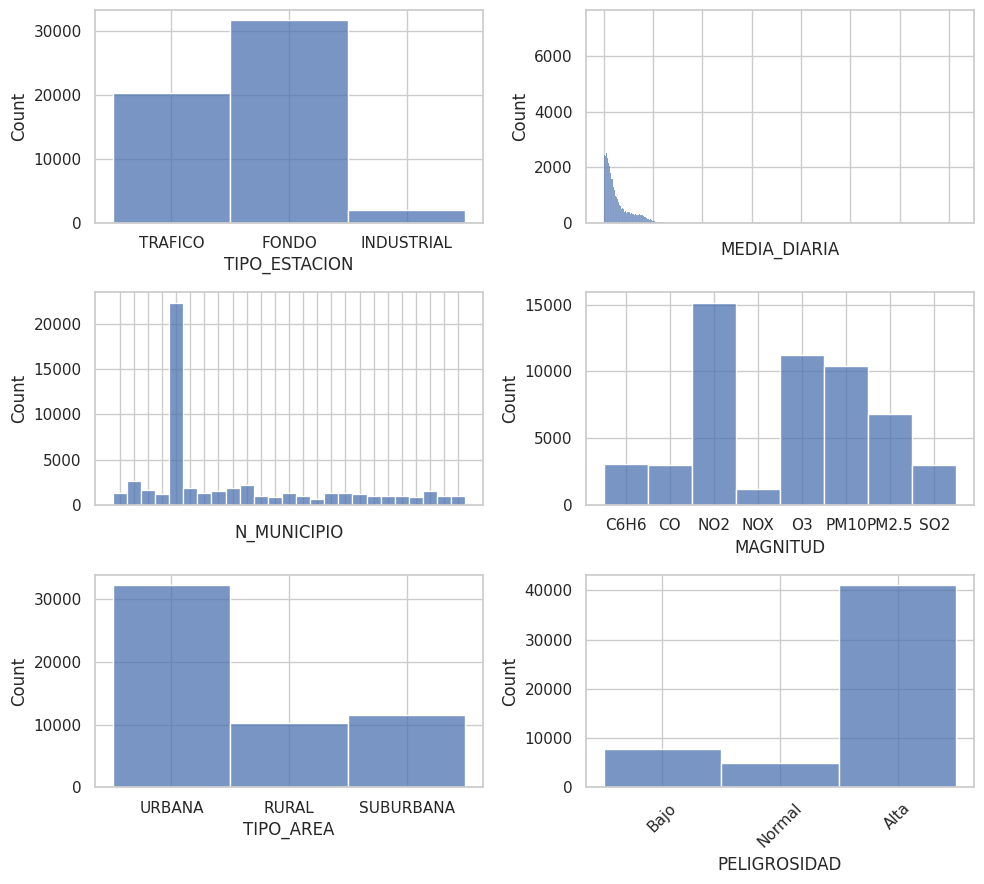

In [47]:
sns.set(style= 'whitegrid')

fig, axis = plt.subplots(3, 2, figsize=(10, 9))

# Histogramas
sns.histplot(ax=axis[0, 0], data=madrid_df, x= 'TIPO_ESTACION')
sns.histplot(ax=axis[0, 1], data=madrid_df, x= 'MEDIA_DIARIA').set_xticklabels([])
sns.histplot(ax=axis[1, 0], data=madrid_df, x= 'N_MUNICIPIO').set_xticklabels([])
sns.histplot(ax=axis[1, 1], data=madrid_df, x= 'MAGNITUD')
sns.histplot(ax=axis[2, 0], data=madrid_df, x= 'TIPO_AREA')
sns.histplot(ax=axis[2, 1], data=madrid_df, x= 'PELIGROSIDAD')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- The first graph shows the danger by type of station, which are traffic, background or industrial. The type of station that has the most cases with a low danger is industrial, which may indicate that air pollution in industrial areas is lower than expected.

- The second graph shows the daily average of the danger, which is the average of the danger values for each day. The daily average decreases as time progresses, which may indicate that air pollution has been reduced in the period analyzed.

- The third graph shows the danger by municipality number, which is a numerical code that identifies each municipality. There is a great variation between municipalities, some have a low danger, others a normal and others a high. This may indicate that air pollution depends on local factors, such as location, climate, economic activity, etc.

- The fourth graph shows the danger by magnitude, which is the type of pollutant that is measured. There are eight magnitudes: C6H6, CO, NO2, NOx, O3, PM10, PM2.5 and SO2. The magnitudes that have the most cases with a low danger are NO2 and NOx, which are pollutants that come mainly from the combustion of vehicles. The magnitudes that have the most cases of high danger are C6H6 and SO2, which are pollutants that come mainly from industrial sources.

- The fifth graph shows the danger by type of area, which can be urban, rural or suburban. The type of area that has the most cases with a low danger is rural, which may indicate that air pollution in cities is greater than expected. The type of area that has the most cases with high danger is urban.

- The sixth graph shows the danger in general, without distinguishing by any other variable. Most cases have a low hazard, which may indicate that air pollution is not a serious problem in the data set. However, there are some cases with a normal or high hazard, which may indicate that there are situations or places where air pollution is a risk to health and the environment.

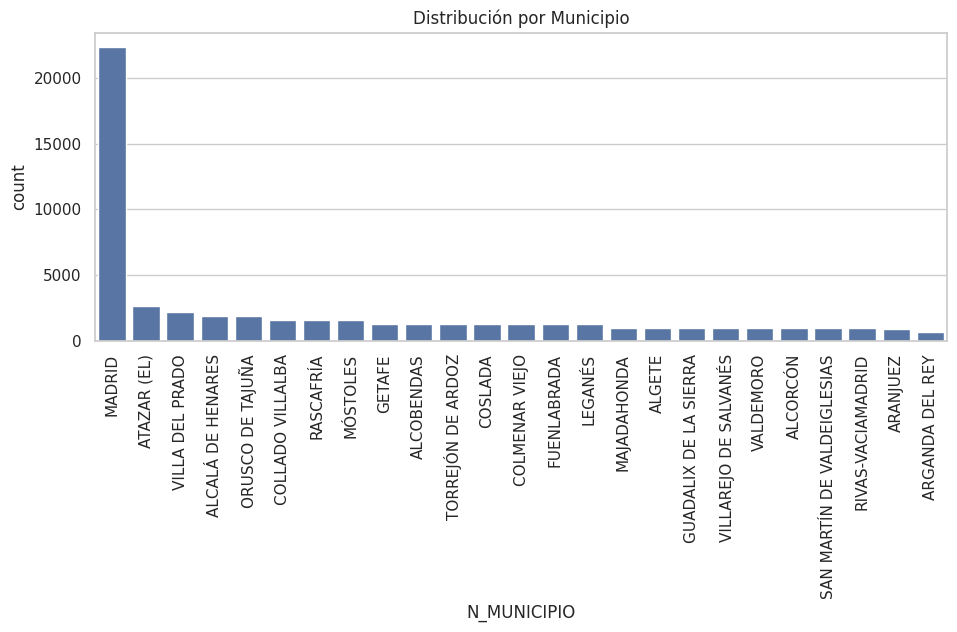

In [48]:
# Distribución de datos en la columna 'PROVINCIA', con las provincias ordenadas por frecuencia en orden descendente en el eje x. 
# Proporciona una visualización de cuántas veces aparece cada provincia en tus datos.
sns.set(style="whitegrid")

plt.figure(figsize=(11, 4))

# Suponiendo que clean_df es tu DataFrame y tiene una columna 'PROVINCIA'
sns.countplot(data=madrid_df, x='N_MUNICIPIO', order = madrid_df['N_MUNICIPIO'].value_counts().index)

plt.title('Distribución por Municipio')
plt.xticks(rotation=90)
plt.show()

- The municipality of the Community of Madrid that has the greatest number of instances in our data is Madrid.

### **3. Analysis multivariate**

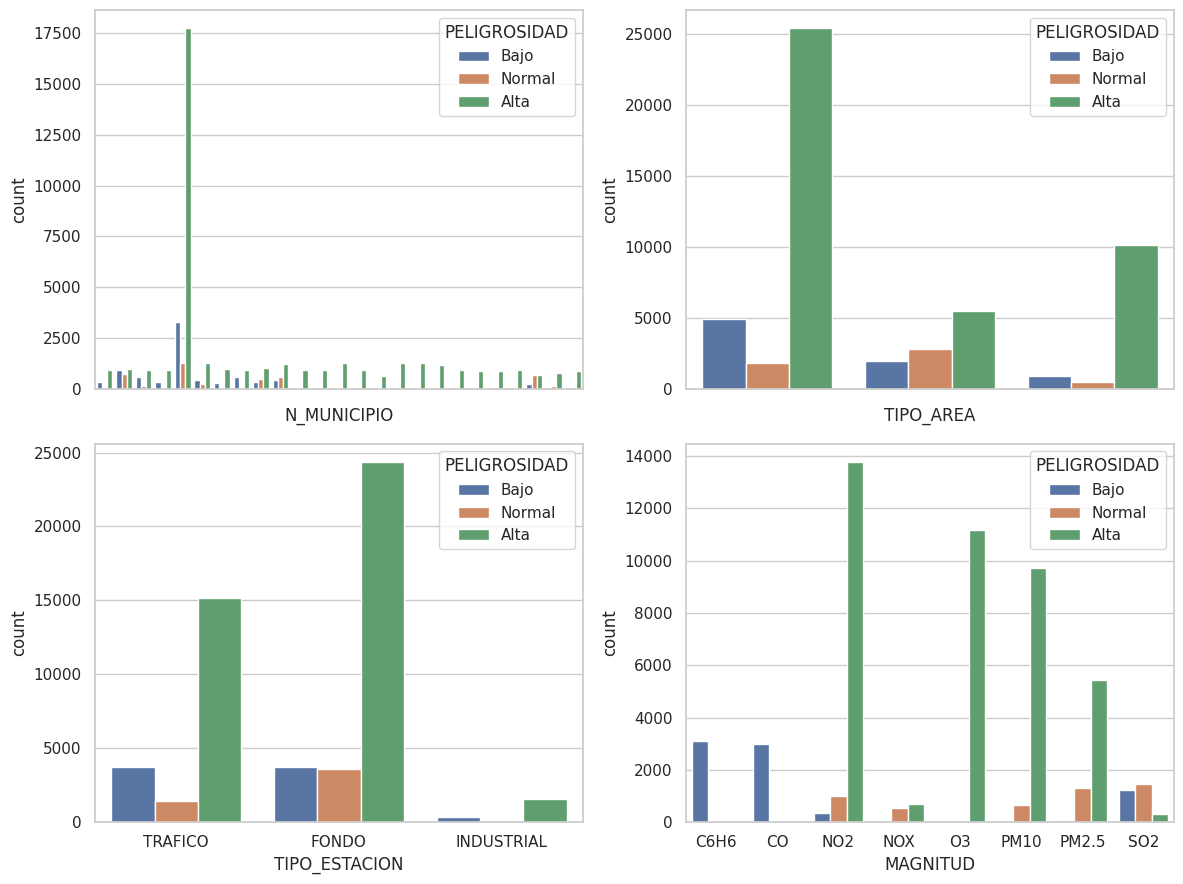

In [49]:
# Análisis Categórico-categórico
fig, axis = plt.subplots(2, 2, figsize = (12, 9))

sns.countplot(ax = axis[0, 0], data = madrid_df, x = 'N_MUNICIPIO', hue = 'PELIGROSIDAD').set_xticklabels([])
sns.countplot(ax = axis[0, 1], data = madrid_df, x = 'TIPO_AREA', hue = 'PELIGROSIDAD').set_xticklabels([])
sns.countplot(ax = axis[1, 0], data = madrid_df, x = 'TIPO_ESTACION', hue = 'PELIGROSIDAD')
sns.countplot(ax = axis[1, 1], data = madrid_df, x = 'MAGNITUD', hue = 'PELIGROSIDAD')

plt.tight_layout()
plt.show()


- In the first graph, you can see that most municipalities have a low danger, except for some that have a normal or high danger. This means that air pollution is not a serious problem in most municipalities, but there are some that require more attention and prevention measures.

- In the second graph, you can see that there is a type of area that has a very high value with a low danger. This means that this type of area has a low exposure to air pollution, which may be due to its geographical location, its climate, its vegetation, etc.

- In the third graph, you can see that the type of station that has a highest value with a low danger is the industrial one. This means that the stations that measure air pollution in industrial areas have a low incidence of pollutants that pose a risk to health and the environment.

- In the fourth graph, you can see that the magnitudes that have the values with the highest danger are NO2 and PM2.5. These magnitudes correspond to nitrogen dioxide and particles with a diameter of 2.5 micrometers, which are pollutants that originate mainly from the combustion of vehicle engines.

In [50]:
madrid_df.columns

Index(['N_MUNICIPIO', 'MAGNITUD', 'TIPO_AREA', 'TIPO_ESTACION', 'LATITUD',
       'LONGITUD', 'MEDIA_DIARIA', 'PELIGROSIDAD'],
      dtype='object')

In [51]:
# Lista de columnas que quieres factorizar
factorize_col = ['N_MUNICIPIO', 'MAGNITUD', 'TIPO_AREA', 'TIPO_ESTACION']

# Diccionario para guardar las correspondencias para cada columna
correspondencias = {}

for col in factorize_col:
    # Aplicar pd.factorize a la columna
    labels, unique = pd.factorize(madrid_df[col])

    # Actualizar el DataFrame con la columna factorizada
    madrid_df[col + '_N'] = labels

    # Guardar la correspondencia en el diccionario usando un rango para representar cada valor único
    correspondencias[col] = dict(zip(unique, range(len(unique))))

# Ahora puedes revisar el DataFrame para confirmar los cambios
madrid_df.drop(factorize_col, axis= 1, inplace= True)

In [52]:
# Guardar el diccionario en un archivo .pk
with open('../data/interim/factorize_values/facto_madrid.pk', 'wb') as file:
    pickle.dump(correspondencias, file)

In [53]:
correspondencias

{'N_MUNICIPIO': {'ALCOBENDAS': 0,
  'ATAZAR (EL)': 1,
  'COLLADO VILLALBA': 2,
  'FUENLABRADA': 3,
  'MADRID': 4,
  'ALCALÁ DE HENARES': 5,
  'COLMENAR VIEJO': 6,
  'MÓSTOLES': 7,
  'ORUSCO DE TAJUÑA': 8,
  'VILLA DEL PRADO': 9,
  'VALDEMORO': 10,
  'RIVAS-VACIAMADRID': 11,
  'TORREJÓN DE ARDOZ': 12,
  'VILLAREJO DE SALVANÉS': 13,
  'ARGANDA DEL REY': 14,
  'COSLADA': 15,
  'GETAFE': 16,
  'LEGANÉS': 17,
  'MAJADAHONDA': 18,
  'ALCORCÓN': 19,
  'ALGETE': 20,
  'ARANJUEZ': 21,
  'RASCAFRÍA': 22,
  'SAN MARTÍN DE VALDEIGLESIAS': 23,
  'GUADALIX DE LA SIERRA': 24},
 'MAGNITUD': {'C6H6': 0,
  'CO': 1,
  'NO2': 2,
  'NOX': 3,
  'O3': 4,
  'PM10': 5,
  'PM2.5': 6,
  'SO2': 7},
 'TIPO_AREA': {'URBANA': 0, 'RURAL': 1, 'SUBURBANA': 2},
 'TIPO_ESTACION': {'TRAFICO': 0, 'FONDO': 1, 'INDUSTRIAL': 2}}

In [54]:
for col, mapping in correspondencias.items():
    filename = f'../data/interim/diccionarios/{col}_correspondencia.pkl'

    with open(filename, 'wb') as file:
        pickle.dump(mapping, file)

    print(f'Mapeo de "{col}" guardado en "{filename}"')


Mapeo de "N_MUNICIPIO" guardado en "../data/interim/diccionarios/N_MUNICIPIO_correspondencia.pkl"
Mapeo de "MAGNITUD" guardado en "../data/interim/diccionarios/MAGNITUD_correspondencia.pkl"
Mapeo de "TIPO_AREA" guardado en "../data/interim/diccionarios/TIPO_AREA_correspondencia.pkl"
Mapeo de "TIPO_ESTACION" guardado en "../data/interim/diccionarios/TIPO_ESTACION_correspondencia.pkl"


In [55]:
madrid_df.to_csv('../data/processed/factorize_csv/madrid_fct.csv', index= False)

In [56]:
madrid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53931 entries, 0 to 53930
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LATITUD          53931 non-null  float64
 1   LONGITUD         53931 non-null  float64
 2   MEDIA_DIARIA     53931 non-null  float64
 3   PELIGROSIDAD     53931 non-null  object 
 4   N_MUNICIPIO_N    53931 non-null  int64  
 5   MAGNITUD_N       53931 non-null  int64  
 6   TIPO_AREA_N      53931 non-null  int64  
 7   TIPO_ESTACION_N  53931 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 3.3+ MB


TypeError: can't multiply sequence by non-int of type 'float'

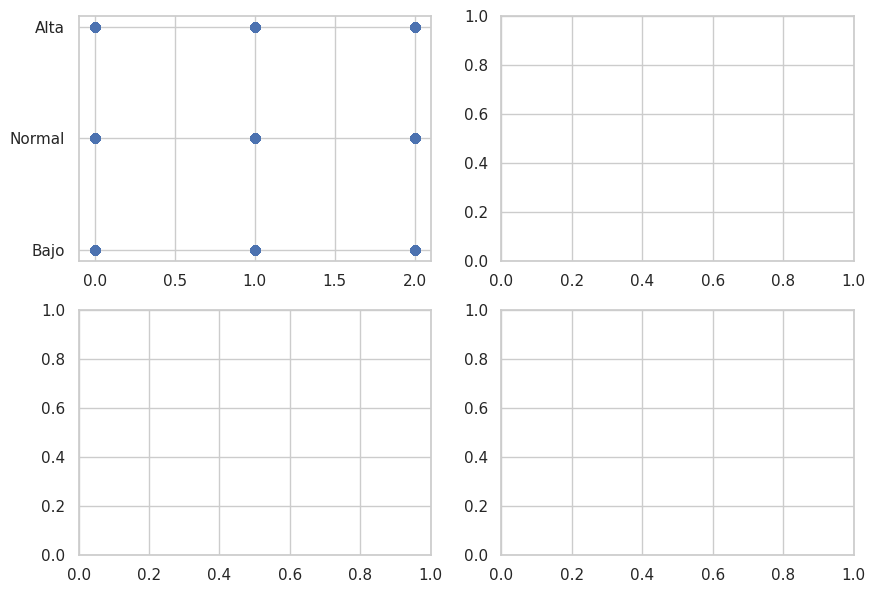

In [64]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# Create a multiple scatter diagram
sns.regplot(ax = axis[0, 0], data = madrid_df, x = 'TIPO_AREA_N', y = 'PELIGROSIDAD')
sns.heatmap(madrid_df[['PELIGROSIDAD', 'TIPO_AREA_N']].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = madrid_df, x = 'N_MUNICIPIO_N', y = 'PELIGROSIDAD').set(ylabel=None)
sns.heatmap(madrid_df[['PELIGROSIDAD', 'N_MUNICIPIO_N']].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

- The upper left subgraph shows the relationship between the type of area and the danger. The scatter diagram shows that there is a negative trend between the variables, that is, the greater the type of area, the less dangerous it is. The heat map shows that the correlation coefficient between the variables is -0.11, indicating a weak and negative correlation.

- The upper right subgraph shows the relationship between the municipality number and the danger. The scatter diagram shows that there is no clear trend between the variables, that is, there is no linear relationship between the municipality number and the danger. The heat map shows that the correlation coefficient between the variables is -0.03, indicating a very weak and negative correlation.

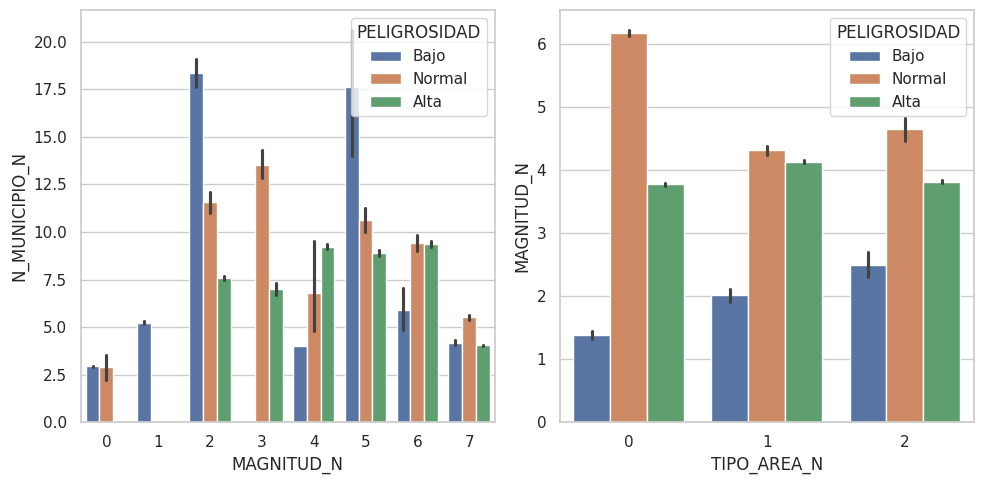

In [61]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 2)

sns.barplot(ax = axis[0], data = madrid_df, x = 'MAGNITUD_N', y = 'N_MUNICIPIO_N', hue = 'PELIGROSIDAD')
sns.barplot(ax = axis[1], data = madrid_df, x = 'TIPO_AREA_N', y = 'MAGNITUD_N', hue = 'PELIGROSIDAD')

plt.tight_layout()

plt.show()

It is observed that the danger of air pollution varies depending on the type of pollutant and the type of area. The bar graphs show the distribution of danger levels for each magnitude category, municipality and area.

**In the graph on the left, you can see that:**

- El contaminante con mayor nivel de peligrosidad es el C6H6 (benceno), que tiene un valor de MAGNITUD_N de 0. La mayoría de los municipios tienen un nivel de peligrosidad de 1 o 2 para este contaminante, lo que indica un riesgo alto para la salud y el medio ambiente.

- El contaminante con menor nivel de peligrosidad es el CO (monóxido de carbono), que tiene un valor de MAGNITUD_N de 1. La mayoría de los municipios tienen un nivel de peligrosidad de 0 para este contaminante, lo que indica un riesgo bajo para la salud y el medio ambiente.

- Los demás contaminantes tienen niveles de peligrosidad variados, dependiendo del municipio.

**In the graph on the right, you can see that:**

- El tipo de área con mayor nivel de peligrosidad es el urbano, que tiene un valor de TIPO_AREA_N de 0. La mayoría de los contaminantes tienen un nivel de peligrosidad de 1 o 2 en este tipo de área, lo que indica una mayor exposición a la contaminación del aire en las ciudades.

- El tipo de área con menor nivel de peligrosidad es el rural, que tiene un valor de TIPO_AREA_N de 2. La mayoría de los contaminantes tienen un nivel de peligrosidad de 0 en este tipo de área, lo que indica una menor exposición a la contaminación del aire en las zonas rurales.

- El tipo de área suburbano, que tiene un valor de TIPO_AREA_N de 1, tiene niveles de peligrosidad intermedios, dependiendo del contaminante.

ValueError: could not convert string to float: 'Bajo'

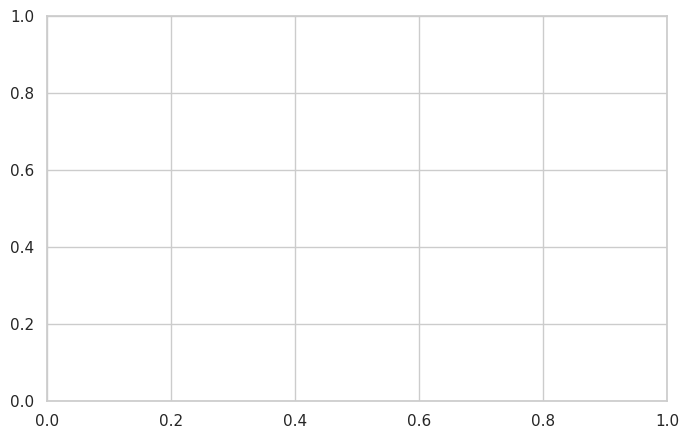

In [65]:
# Correlation map
fig, axis = plt.subplots(figsize = (8, 5))
sns.heatmap(madrid_df[['N_MUNICIPIO_N', 'MAGNITUD_N', 'TIPO_AREA_N', 'TIPO_ESTACION_N', 'MEDIA_DIARIA', 'PELIGROSIDAD']].corr(), annot = True, fmt = ".2f")

plt.tight_layout()
plt.show()

- La variable que tiene mayor correlación positiva con PELIGROSIDAD_N es MEDIA_DIARIA, con un coeficiente de 0.42.

Esto significa que a mayor valor de la media diaria del contaminante, mayor es el nivel de peligrosidad de la contaminación del aire.

- La variable que tiene mayor correlación positiva con TIPO_ESTACION_N es TIPO_AREA_N, con un coeficiente de 0.39.

Esto significa que hay una relación entre el tipo de área y el tipo de estación donde se mide la contaminación del aire.

- La variable que tiene menor correlación con todas las demás es N_MUNICIPIO_N, con coeficientes entre -0.03 y 0.13.

Esto significa que el número de municipio no tiene mucha influencia en las demás variables.

- La peligrosidad disminuye a medida que aumenta el valor de MAGNITUD_N, que representa el tipo de contaminante.

Esto se debe a que los contaminantes con valores más altos de MAGNITUD_N tienen umbrales más altos de peligrosidad que los contaminantes con valores más bajos de MAGNITUD_N. Por ejemplo, el CO (monóxido de carbono) tiene un valor de MAGNITUD_N de 1 y un umbral alto de peligrosidad de 4 mg/m3, mientras que el C6H6 (benceno) tiene un valor de MAGNITUD_N de 0 y un umbral alto de peligrosidad de 5 µg/m3.

- La peligrosidad también disminuye a medida que aumenta el valor de TIPO_AREA_N, que representa el tipo de área donde se mide la contaminación.

Esto se debe a que las áreas urbanas tienen mayor exposición a la contaminación del aire que las áreas rurales o suburbanas, debido al mayor tráfico y actividad industrial. Por ejemplo, el valor de TIPO_AREA_N es 0 para las áreas urbanas, 1 para las suburbanas y 2 para las rurales.

### **4. Feature engineering**
**Outliers analysis**

In [28]:
madrid_df.describe()

,LATITUD,LONGITUD,MEDIA_DIARIA,N_MUNICIPIO_N,MAGNITUD_N,TIPO_AREA_N,TIPO_ESTACION_N,PELIGROSIDAD_N
count,53931.000000,53931.000000,53931.000000,53931.000000,53931.000000,53931.000000,53931.000000,53931.000000
mean,40.446810,-3.694519,23.964349,8.059966,3.631733,0.616751,0.658897,1.617511
std,0.175136,0.227024,26.505437,6.521695,1.907187,0.814704,0.543885,0.724962
min,40.033270,-4.398100,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.341900,-3.754500,5.333333,4.000000,2.000000,0.000000,0.000000,2.000000
50%,40.421670,-3.689720,14.833333,4.000000,4.000000,0.000000,1.000000,2.000000
75%,40.479330,-3.580560,33.666667,12.000000,5.000000,1.000000,1.000000,2.000000
max,40.909000,-3.221100,715.083333,24.000000,7.000000,2.000000,2.000000,2.000000


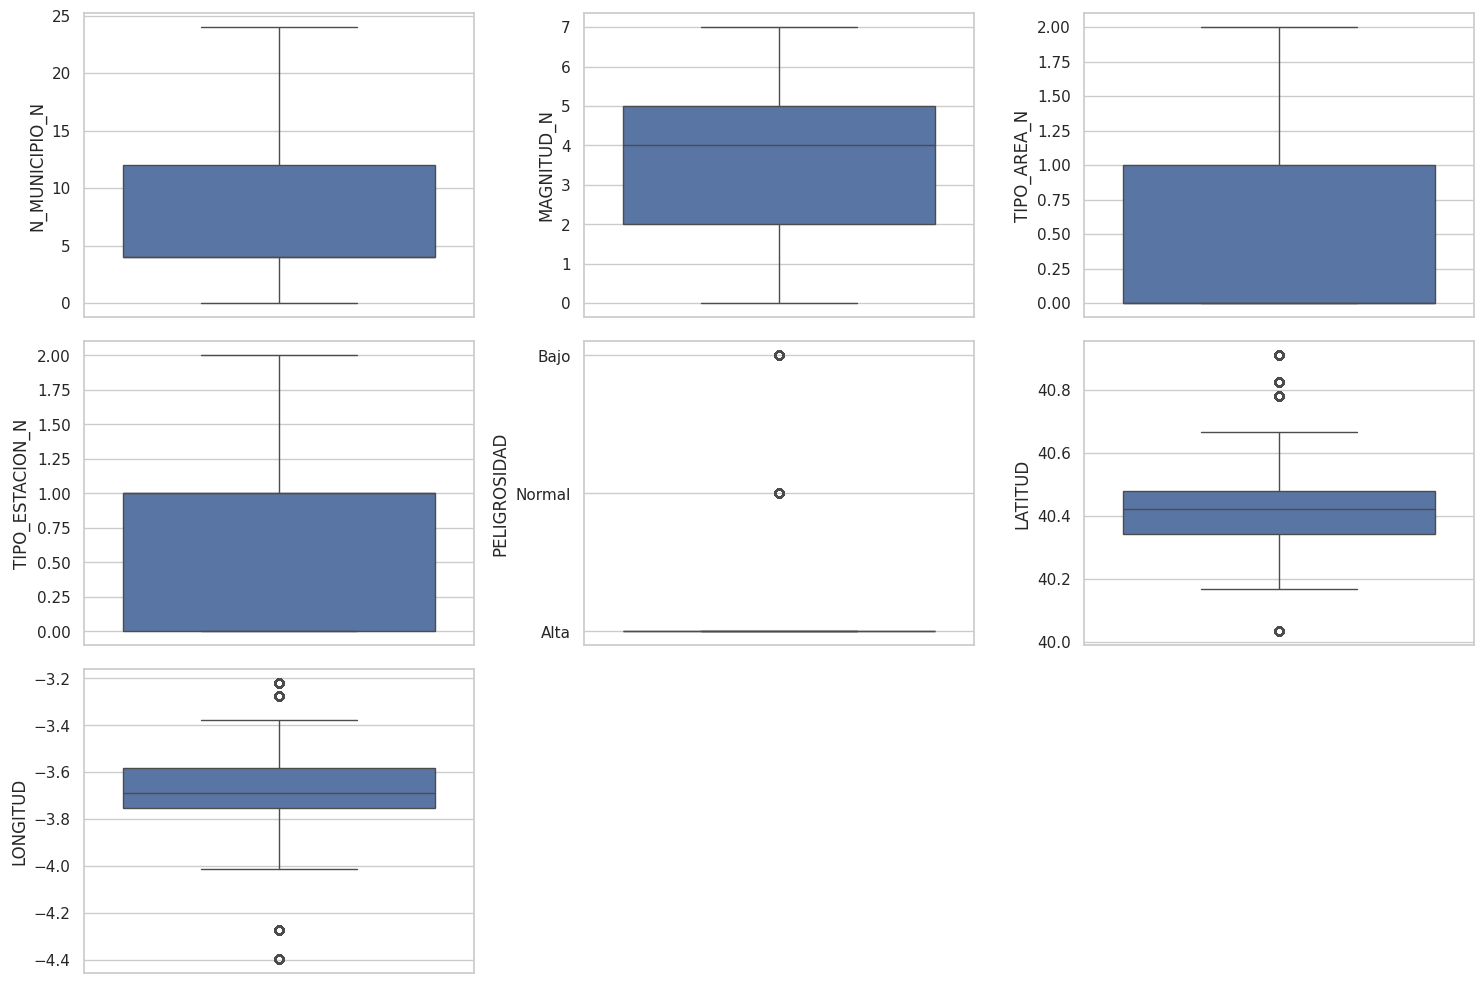

In [66]:
columnas = ['N_MUNICIPIO_N', 'MAGNITUD_N', 'TIPO_AREA_N', 'TIPO_ESTACION_N', 'PELIGROSIDAD', 'LATITUD', 'LONGITUD']

# Crear una figura con subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Iterar sobre cada eje y la correspondiente columna
for i in range(3):
    for j in range(3):
        # Calcula el índice de la columna basado en i y j
        idx = i * 3 + j
        # Si el índice es menor que el número de columnas, dibuja el boxplot
        if idx < len(columnas):
            sns.boxplot(ax= axes[i, j], data= madrid_df, y= columnas[idx])
        # Si no, elimina el eje
        else:
            fig.delaxes(axes[i, j])

# Ajustar el layout y mostrar el plot
plt.tight_layout()
plt.show()

**Really don't have to remove outliers, so leave the dataset the same.**

In [79]:
madrid_df[madrid_df['PELIGROSIDAD'] == 'Normal']

,MEDIA_DIARIA,PELIGROSIDAD,N_MUNICIPIO_N,MAGNITUD_N,TIPO_AREA_N,TIPO_ESTACION_N
665,2.175000,Normal,2,0,0,0
666,2.045833,Normal,2,0,0,0
679,2.179167,Normal,2,0,0,0
680,2.120833,Normal,2,0,0,0
704,2.062500,Normal,2,0,0,0
...,...,...,...,...,...,...
53926,2.250000,Normal,9,7,1,1
53927,2.791667,Normal,9,7,1,1
53928,2.875000,Normal,9,7,1,1
53929,3.000000,Normal,9,7,1,1


In [80]:
madrid_df = madrid_df.drop(['LATITUD', 'LONGITUD'], axis= 1)
madrid_df

KeyError: "['LATITUD', 'LONGITUD'] not found in axis"

In [72]:
madrid_df.to_csv('../data/processed/factorize_csv/sin_LL.csv', index=False)

In [73]:
# Para guardar el DataFrame en un archivo pickle
madrid_df.to_pickle("../data/interim/factorize_values/madrid_sin_LL.pk")

### **5. Feature scaling**

- Split the data in train and test.

In [81]:
from sklearn.model_selection import train_test_split

#Divido dataset en train y test

X = madrid_df.drop('PELIGROSIDAD', axis =1)
y = madrid_df['PELIGROSIDAD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 23)

X_train.to_csv('../data/processed/train_test_madrid/Xtrain.csv', index=False)
X_test.to_csv('../data/processed/train_test_madrid/Xtest.csv', index=False)
y_train.to_csv('../data/processed/train_test_madrid/ytrain.csv', index=False, header=['PELIGROSIDAD_N'])
y_test.to_csv('../data/processed/train_test_madrid/ytest.csv', index=False, header=['PELIGROSIDAD_N'])

In [82]:
X_train.head()

,MEDIA_DIARIA,N_MUNICIPIO_N,MAGNITUD_N,TIPO_AREA_N,TIPO_ESTACION_N
5258,0.587500,7,1,2,1
50100,19.041667,10,6,2,1
994,1.454167,2,0,0,0
38239,21.166667,4,5,2,1
50677,7.791667,13,6,2,0


In [87]:
y_train

5258     Bajo
50100    Alta
994      Bajo
38239    Alta
50677    Alta
         ... 
9704     Alta
11190    Alta
26569    Alta
9256     Alta
41555    Alta
Name: PELIGROSIDAD, Length: 37751, dtype: object

- Scaling the data.

In [103]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns= X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns= X_test.columns)

X_train_scaled_df.to_csv('../data/processed/scaler_madrid/scaled_X_train.csv', index=False)
X_test_scaled_df.to_csv('../data/processed/scaler_madrid/scaled_X_test.csv', index=False)